# Food Prediction using Transfer Learning

### We will use 10% of dataset -> [FOOD101](https://www.kaggle.com/datasets/dansbecker/food-101)

### What we're going to do ?
We're going to go through the follow with TensorFlow:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
- Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

In [2]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In the original [Food101](https://www.kaggle.com/datasets/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

### Downloading and preprocessing the data

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-09-01 17:29:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   209MB/s    in 11s     

2023-09-01 17:30:04 (147 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_foo

Let's use the `image_dataset_from_directory()` function to turn our images and labels into a `tf.data.Dataset`, a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
# Create checkpoint callback to save model for later use
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor = "val_accuracy", # save the model weights which score the best val accuracy
                                                         save_best_only = True) # only keep the best model weights on file

Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [7]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name = "data_augmentation")

 We'll be able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

In [8]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_model.trainable = False

# Setup the model architecture with trainable top layers
inputs = layers.Input(shape = (224,224, 3), name = 'input_layer') # Shape of the input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "Output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


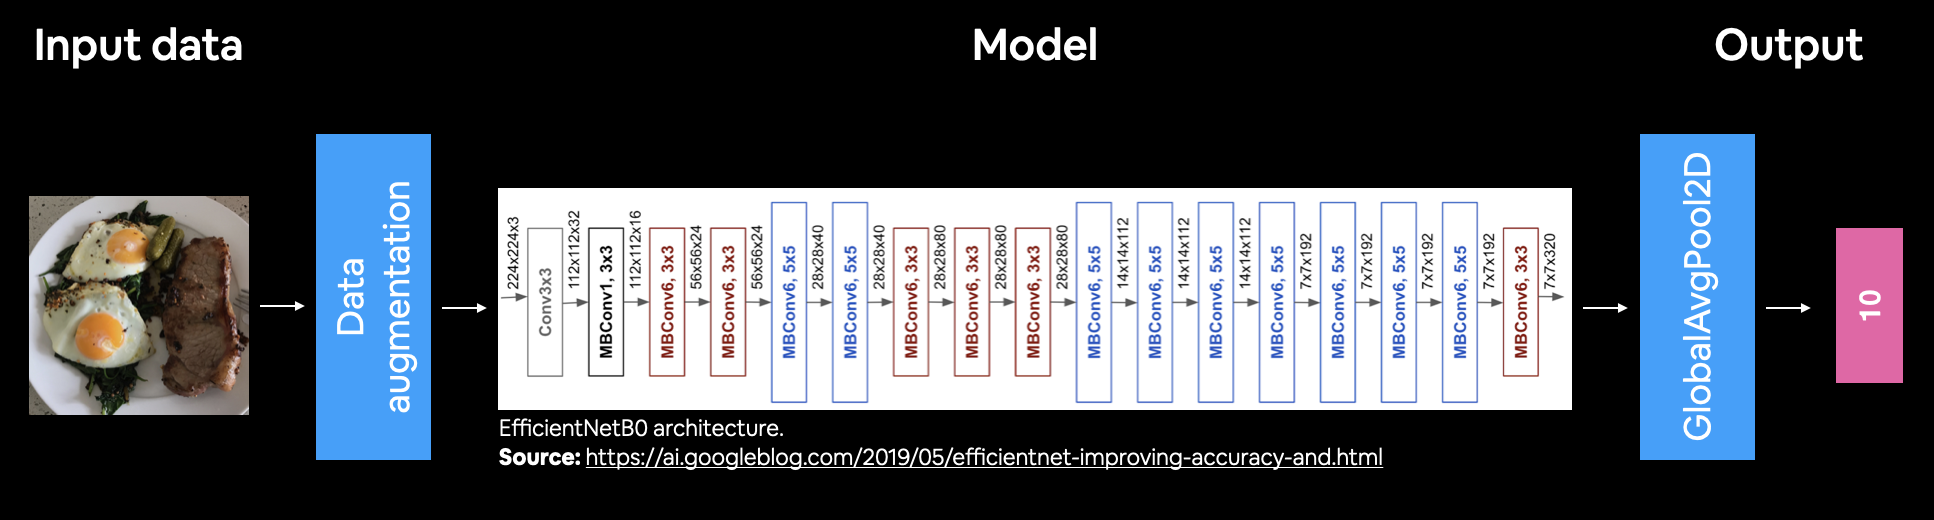

Model created. Let's inspect it.

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [10]:
# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.5 * len(test_data)),
                                           callbacks = [checkpoint_callback])# save best model weights to file

Epoch 1/5
237/237 [==============================] - 154s 580ms/step - loss: 3.3785 - accuracy: 0.2685 - val_loss: 2.3592 - val_accuracy: 0.4770
Epoch 2/5
237/237 [==============================] - 109s 459ms/step - loss: 2.1999 - accuracy: 0.4986 - val_loss: 1.9262 - val_accuracy: 0.5320
Epoch 3/5
237/237 [==============================] - 91s 380ms/step - loss: 1.8124 - accuracy: 0.5655 - val_loss: 1.7772 - val_accuracy: 0.5498
Epoch 4/5
237/237 [==============================] - 94s 396ms/step - loss: 1.6108 - accuracy: 0.6026 - val_loss: 1.6948 - val_accuracy: 0.5608
Epoch 5/5
237/237 [==============================] - 77s 325ms/step - loss: 1.4443 - accuracy: 0.6457 - val_loss: 1.6486 - val_accuracy: 0.5690


In [11]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 65s 82ms/step - loss: 1.5790 - accuracy: 0.5840


[1.5789812803268433, 0.5840396285057068]

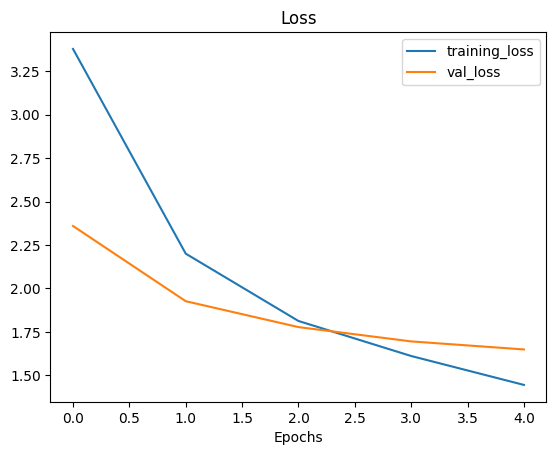

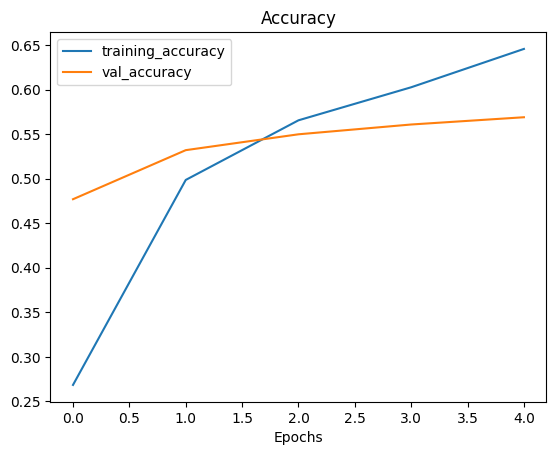

In [12]:
plot_loss_curves(history_all_classes_10_percent)

### Fine-tuning

To fine-tune the base model we'll first set its trainable attribute to True, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [13]:
# Unfreeze all the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

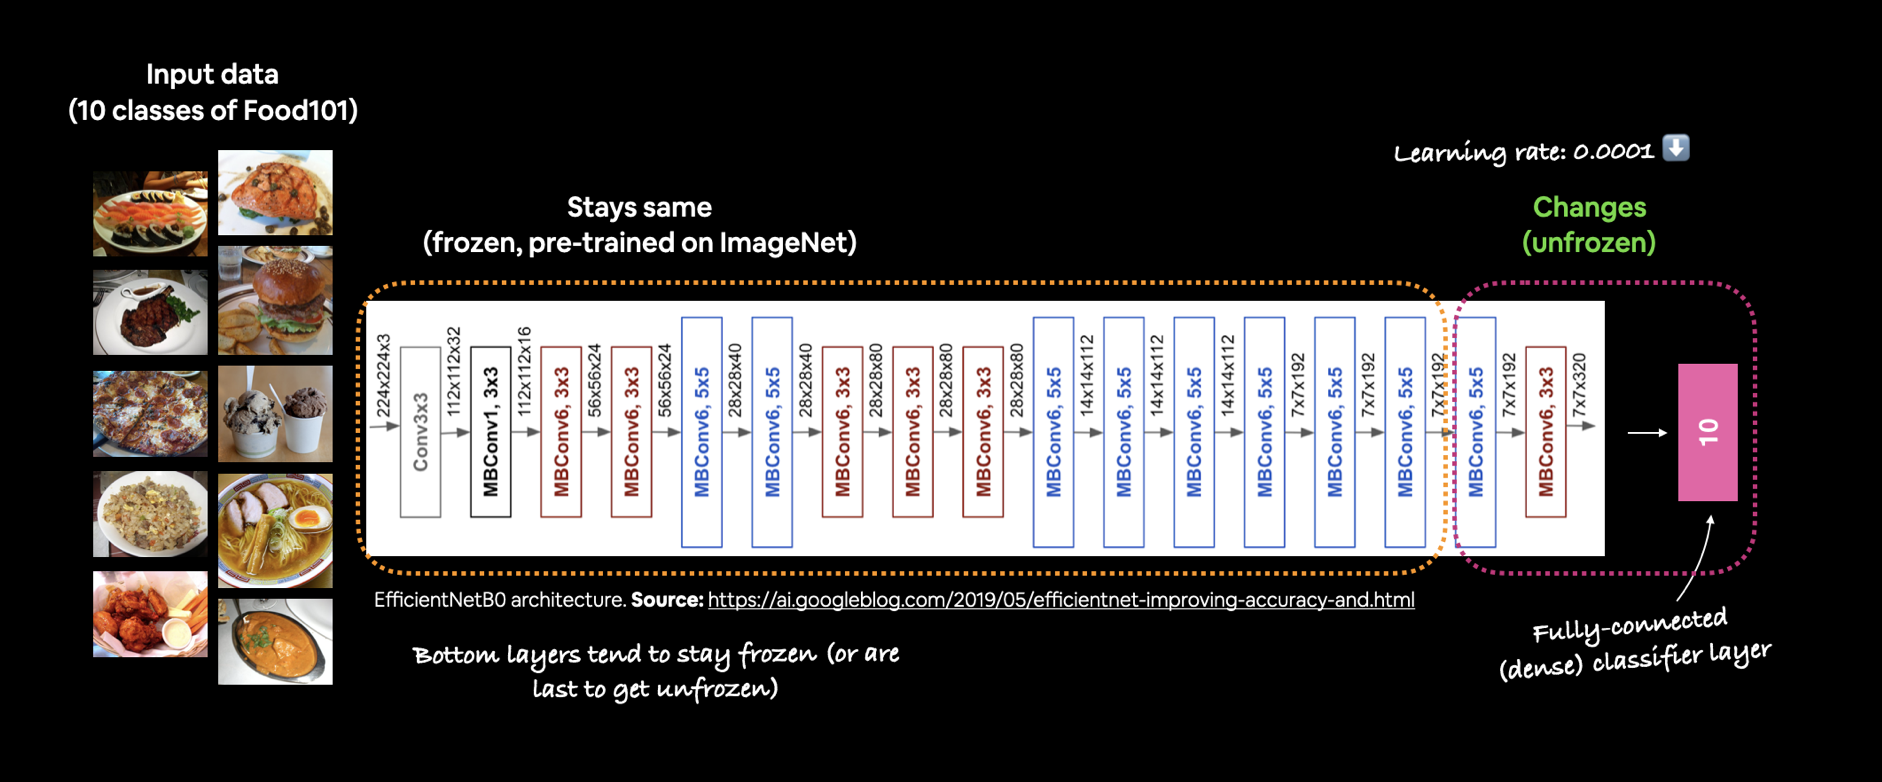

When fine-tuning and unfreezing layers of your pre-trained model, it's common practice to lower the learning rate you used for your feature extraction model. How much by? A 10x lower learning rate is usually a good place to to start.

In [14]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [15]:
# What layers in the model are trainable
for layer in model.layers:
  print(layer.name , layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
Output_layer True


In [16]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [17]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data= test_data,
                                                     validation_steps = int(0.15 * len(test_data)),  # validate on 15% of the test data
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1]) # start from previous last epochs

Epoch 5/10
237/237 [==============================] - 71s 243ms/step - loss: 1.2206 - accuracy: 0.6775 - val_loss: 1.7145 - val_accuracy: 0.5511
Epoch 6/10
237/237 [==============================] - 52s 219ms/step - loss: 1.0829 - accuracy: 0.7110 - val_loss: 1.7126 - val_accuracy: 0.5530
Epoch 7/10
237/237 [==============================] - 51s 213ms/step - loss: 1.0140 - accuracy: 0.7284 - val_loss: 1.6861 - val_accuracy: 0.5622
Epoch 8/10
237/237 [==============================] - 50s 205ms/step - loss: 0.9477 - accuracy: 0.7452 - val_loss: 1.7130 - val_accuracy: 0.5585
Epoch 9/10
237/237 [==============================] - 47s 193ms/step - loss: 0.8866 - accuracy: 0.7657 - val_loss: 1.7529 - val_accuracy: 0.5456
Epoch 10/10
237/237 [==============================] - 48s 200ms/step - loss: 0.8369 - accuracy: 0.7757 - val_loss: 1.7026 - val_accuracy: 0.5614


In [18]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 68s 87ms/step - loss: 1.4934 - accuracy: 0.6059


[1.493436574935913, 0.6059010028839111]

`compare_historys()` function and seeing what the training curves say.

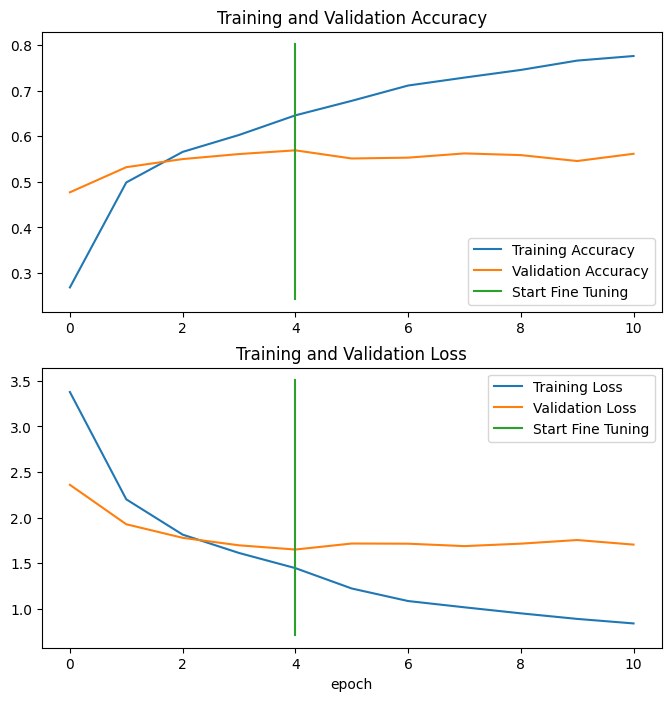

In [19]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, EfficientNetB0 was trained on ImageNet which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

## Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [20]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 70s 86ms/step


In [21]:
# How many predictions are there?
len(pred_probs)

25250

In [22]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [23]:
# How do they look?
pred_probs[:10]

array([[1.6699044e-01, 1.7699011e-04, 1.4522646e-01, ..., 4.0203090e-06,
        3.8890773e-03, 2.7192930e-02],
       [9.2933822e-01, 5.5756320e-09, 4.0362906e-04, ..., 6.4435625e-04,
        2.3962184e-07, 3.3444958e-06],
       [6.0079551e-01, 5.0223051e-03, 6.4255563e-03, ..., 2.1114587e-04,
        4.3492601e-04, 2.0053356e-03],
       ...,
       [1.7696057e-01, 3.5330856e-06, 1.1358343e-03, ..., 4.2760495e-02,
        1.8717251e-03, 1.2975377e-04],
       [1.0181907e-01, 1.6204971e-04, 9.8078869e-02, ..., 9.2660150e-05,
        2.3796970e-04, 7.5016935e-05],
       [6.8347871e-01, 3.5468955e-07, 9.0975442e-04, ..., 2.0096633e-03,
        3.1554039e-06, 7.4576598e-04]], dtype=float32)

In [24]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.6699044e-01 1.7699011e-04 1.4522646e-01 1.6916884e-07 6.6855691e-06
 2.3602192e-06 1.1501172e-04 1.2522658e-05 6.9939527e-03 5.3642783e-04
 1.6760292e-06 4.2120100e-06 1.1148143e-03 6.9254457e-07 4.5439568e-03
 1.5750710e-03 1.6051832e-05 1.5499230e-03 4.2750607e-03 2.1691963e-05
 1.6192925e-03 1.0152983e-05 2.2429557e-04 1.0582279e-04 1.2709246e-03
 1.6187521e-03 8.9727383e-04 4.2929820e-05 1.7886367e-01 1.9494639e-03
 3.5662688e-06 8.2193490e-04 2.9635098e-04 3.0710797e-07 1.5822140e-02
 6.0547759e-06 1.8784149e-04 1.1365364e-03 4.0808406e-02 6.7202702e-05
 4.6788334e-04 5.4931729e-03 1.3740902e-04 1.4193116e-05 9.5874282e-05
 2.5973372e-05 2.2108550e-03 1.2743296e-04 5.3119625e-06 3.4585439e-02
 2.0572294e-04 7.0866809e-05 1.6389295e-02 2.0970428e-01 8.8095803e-06
 1.1221001e-02 2.4920104e-02 2.6488015e-03 1.5663635e-03 4.0611347e-05
 1.2563826e-06 2.7175678e-03 2.1857761e-02 2.

In [25]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis = 1)

# How do they look
pred_classes[:10]

array([53,  0,  0,  0, 29, 78, 29, 46,  9,  0])

In [26]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax())  # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [27]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

## Evaluating our models predictions

In [28]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6059009900990099

In [30]:
from helper_functions import make_confusion_matrix

In [31]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [34]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

101 class names and 25250 predictions and ground truth labels ready to go! Looks like our confusion matrix is going to be a big one!

In [35]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

It looks like the model gets most confused on classes which look visualually similar, such as predicting `filet_mignon` for instances of `pork_chop` and `chocolate_cake` for instances of `tiramisu`.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's `classification_report()` function.

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.22      0.27       250
           1       0.51      0.76      0.61       250
           2       0.72      0.58      0.64       250
           3       0.87      0.47      0.61       250
           4       0.62      0.44      0.51       250
           5       0.43      0.38      0.40       250
           6       0.74      0.77      0.75       250
           7       0.83      0.80      0.82       250
           8       0.34      0.48      0.40       250
           9       0.31      0.72      0.43       250
          10       0.47      0.48      0.47       250
          11       0.88      0.54      0.67       250
          12       0.63      0.66      0.65       250
          13       0.52      0.60      0.56       250
          14       0.61      0.54      0.58       250
          15       0.39      0.38      0.38       250
          16       0.67      0.59      0.63       250
          17       0.30    

In [37]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3576158940397351,
  'recall': 0.216,
  'f1-score': 0.26932668329177056,
  'support': 250},
 '1': {'precision': 0.5108108108108108,
  'recall': 0.756,
  'f1-score': 0.6096774193548387,
  'support': 250},
 '2': {'precision': 0.7164179104477612,
  'recall': 0.576,
  'f1-score': 0.6385809312638581,
  'support': 250},
 '3': {'precision': 0.8740740740740741,
  'recall': 0.472,
  'f1-score': 0.612987012987013,
  'support': 250},
 '4': {'precision': 0.6228571428571429,
  'recall': 0.436,
  'f1-score': 0.5129411764705882,
  'support': 250},
 '5': {'precision': 0.4292237442922374,
  'recall': 0.376,
  'f1-score': 0.40085287846481876,
  'support': 250},
 '6': {'precision': 0.7384615384615385,
  'recall': 0.768,
  'f1-score': 0.7529411764705882,
  'support': 250},
 '7': {'precision': 0.8333333333333334,
  'recall': 0.8,
  'f1-score': 0.816326530612245,
  'support': 250},
 '8': {'precision': 0.3408450704225352,
  'recall': 0.484,
  'f1-score': 0.4,
  'support': 250},
 '9': {'p

In [38]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.26932668329177056,
 'baby_back_ribs': 0.6096774193548387,
 'baklava': 0.6385809312638581,
 'beef_carpaccio': 0.612987012987013,
 'beef_tartare': 0.5129411764705882,
 'beet_salad': 0.40085287846481876,
 'beignets': 0.7529411764705882,
 'bibimbap': 0.816326530612245,
 'bread_pudding': 0.4,
 'breakfast_burrito': 0.4306220095693781,
 'bruschetta': 0.4745098039215686,
 'caesar_salad': 0.671604938271605,
 'cannoli': 0.6470588235294118,
 'caprese_salad': 0.5592592592592593,
 'carrot_cake': 0.576271186440678,
 'ceviche': 0.38367346938775504,
 'cheese_plate': 0.625531914893617,
 'cheesecake': 0.3978201634877384,
 'chicken_curry': 0.47816091954022993,
 'chicken_quesadilla': 0.6487603305785123,
 'chicken_wings': 0.7127659574468085,
 'chocolate_cake': 0.5492424242424242,
 'chocolate_mousse': 0.36608863198458574,
 'churros': 0.7551020408163266,
 'clam_chowder': 0.7233115468409587,
 'club_sandwich': 0.6724890829694323,
 'crab_cakes': 0.39662447257383965,
 'creme_brulee': 0.768,
 'cro

In [39]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33      edamame  0.966469
63     macarons  0.914046
75          pho  0.866142
69      oysters  0.856540
68  onion_rings  0.836066

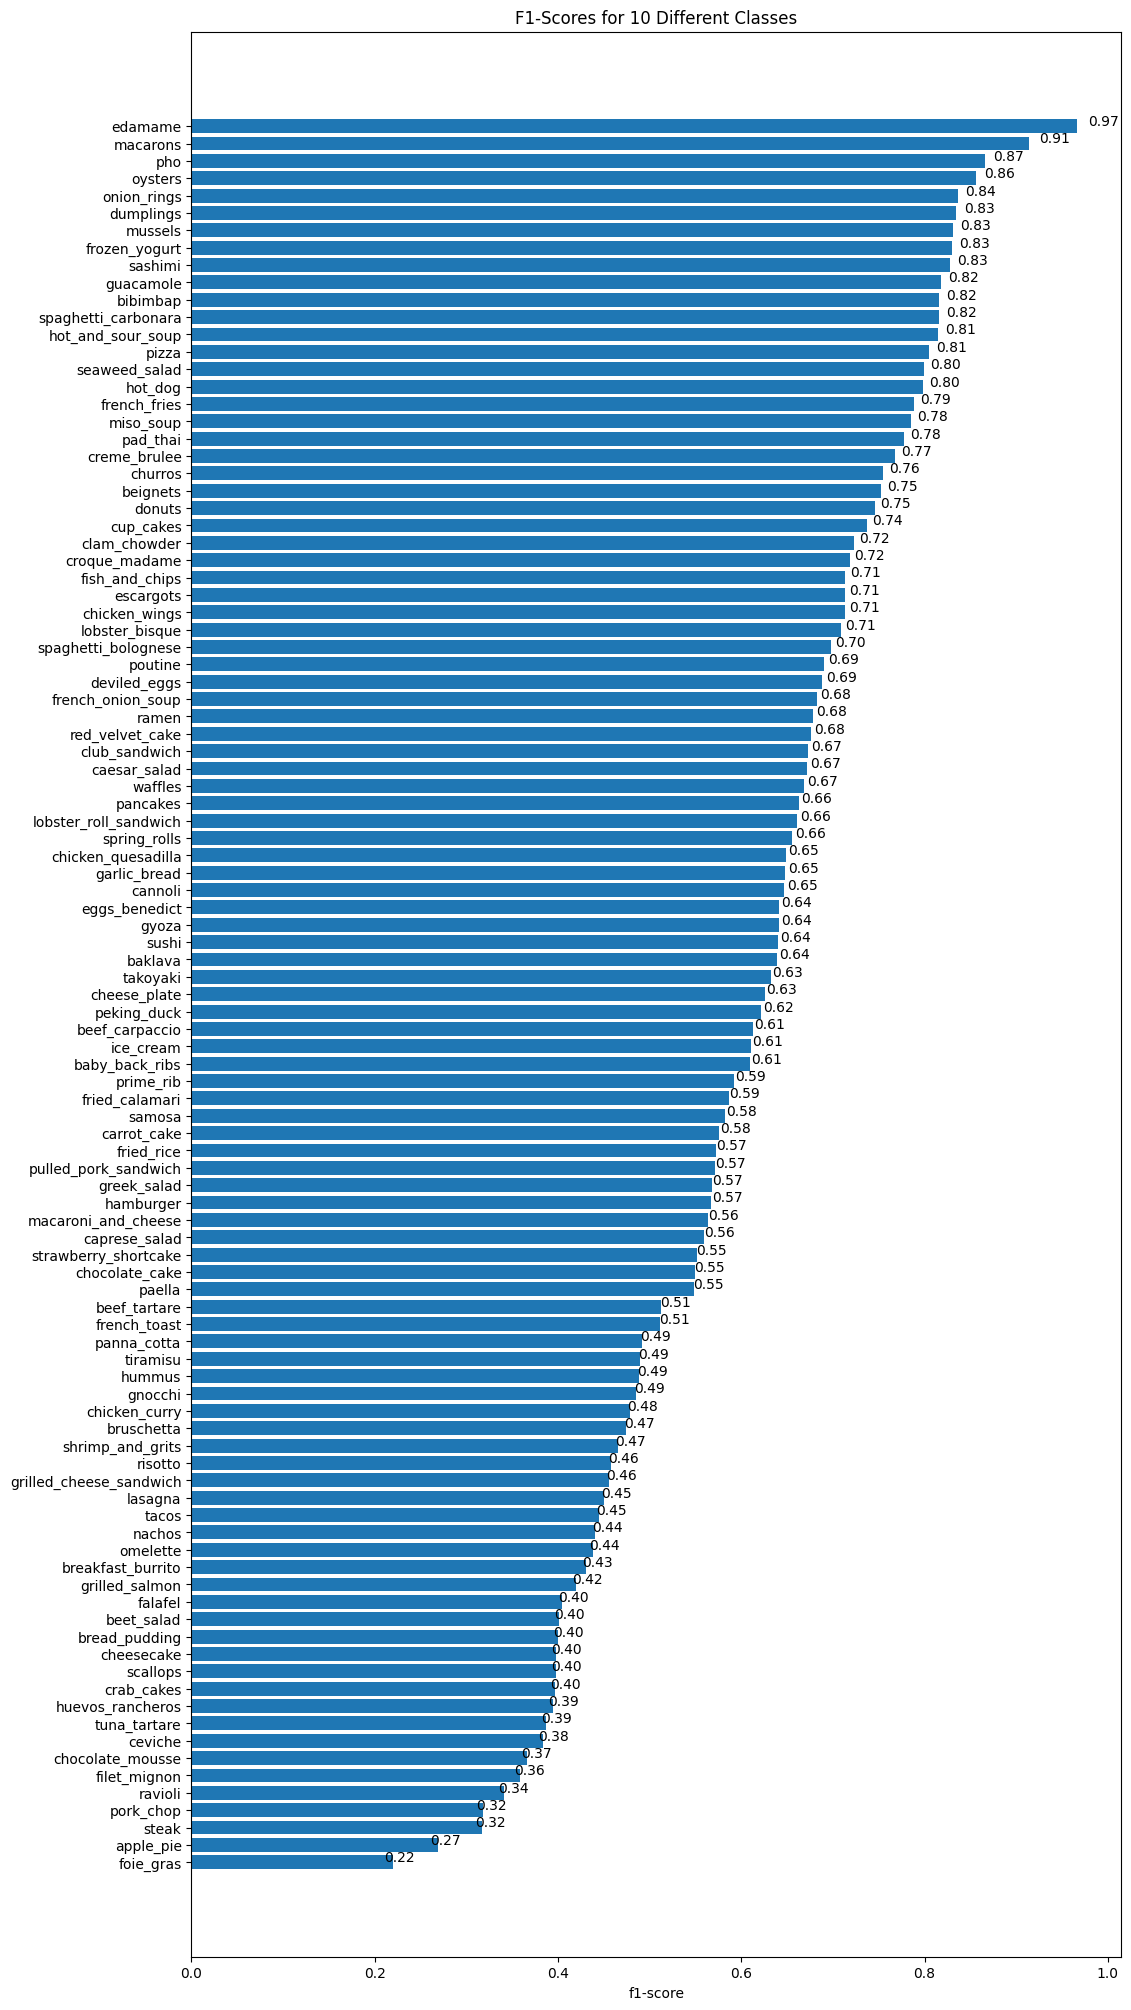

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Visualizing predictions on test images

In [41]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 39ms/step


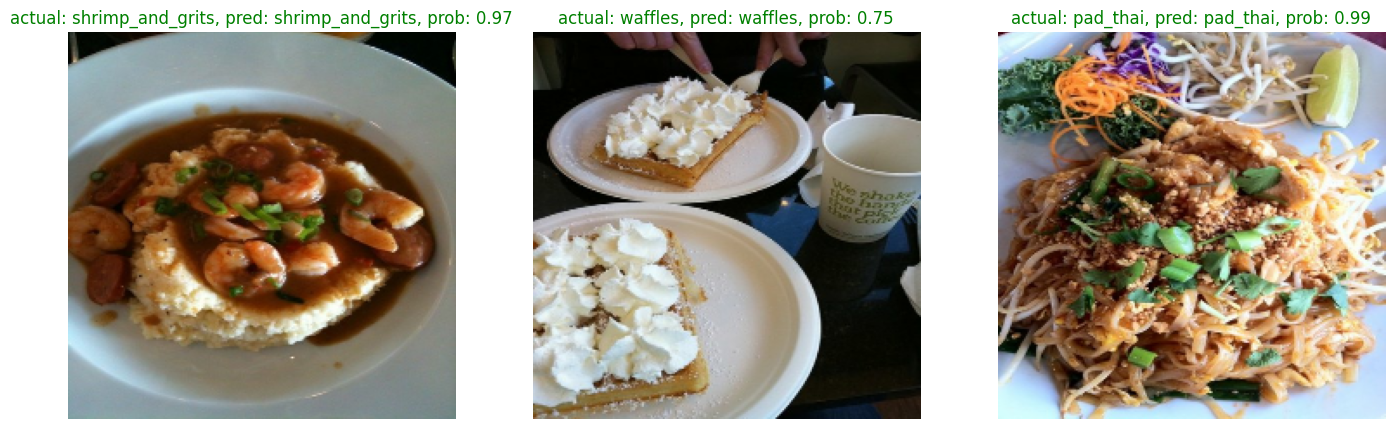

In [47]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Finding the most wrong predictions

These most wrong predictions can help to give further insight into your model's performance.

In [48]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [49]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      53   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      29   

   pred_conf y_true_classname y_pred_classname  
0   0.209704        apple_pie        hamburger  
1   0.929338        apple_pie        apple_pie  
2   0.600796        apple_pie        apple_pie  
3   0.275470        apple_pie        apple_pie  
4   0.366668        apple_pie        cup_cakes

In [50]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      53   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      29   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.209704        apple_pie        hamburger         False  
1   0.929338        apple_pie        apple_pie          True  
2   0.600796        apple_pie        apple_pie          True  
3   0.275470        apple_pie        apple_pie          True  
4   0.366668        apple_pie        cup_cakes         False

In [51]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
14691  b'101_food_classes_10_percent/test/ice_cream/3...      58      79   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
7194   b'101_food_classes_10_percent/test/croque_mada...      28       7   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
722    b'101_food_classes_10_percent/test/baklava/640...       2      85   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
19430  b'101_food_classes_10_percent/test/pork_chop/3...      77       1   
17897  b'101_food_classes_10_percent/test/paella/2986...      71      65   
9110   b'101_food_classes_10_percent/test/falafel/241...      36      31   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
4583   b'101_food_classes_10_percent/test/chicken_cur...      18      60   
9326   b'101_food_classes_10_percent/test/filet_migno...      37      79   
10346  b'101_food_classes_10_percent/test/french_onio...      41      54   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   

       pred_conf       y_true_classname   y_pred_classname  pred_correct  
18001   0.998789               pancakes           omelette         False  
11642   0.997841           garlic_bread         bruschetta         False  
191     0.997653              apple_pie             donuts         False  
14691   0.997577              ice_cream          prime_rib         False  
23797   0.997430                  sushi            sashimi         False  
21810   0.996814               scallops          cup_cakes         False  
7194    0.995797          croque_madame           bibimbap         False  
17855   0.995705                 paella            mussels         False  
722     0.995042                baklava             samosa         False  
15142   0.994907         lobster_bisque          miso_soup         False  
23631   0.994726   strawberry_shortcake    red_velvet_cake         False  
19430   0.993717              pork_chop     baby_back_ribs         False  
17897   0.993376                 paella            mussels         False  
9110    0.993236                falafel             donuts         False  
15359   0.992931  lobster_roll_sandwich          hamburger         False  
4583    0.991187          chicken_curry     lobster_bisque         False  
9326    0.990972           filet_mignon          prime_rib         False  
10346   0.990759      french_onion_soup  hot_and_sour_soup         False  
10847   0.989785         fried_calamari        onion_rings         False  
5114    0.989447          chicken_wings     fish_and_chips         False

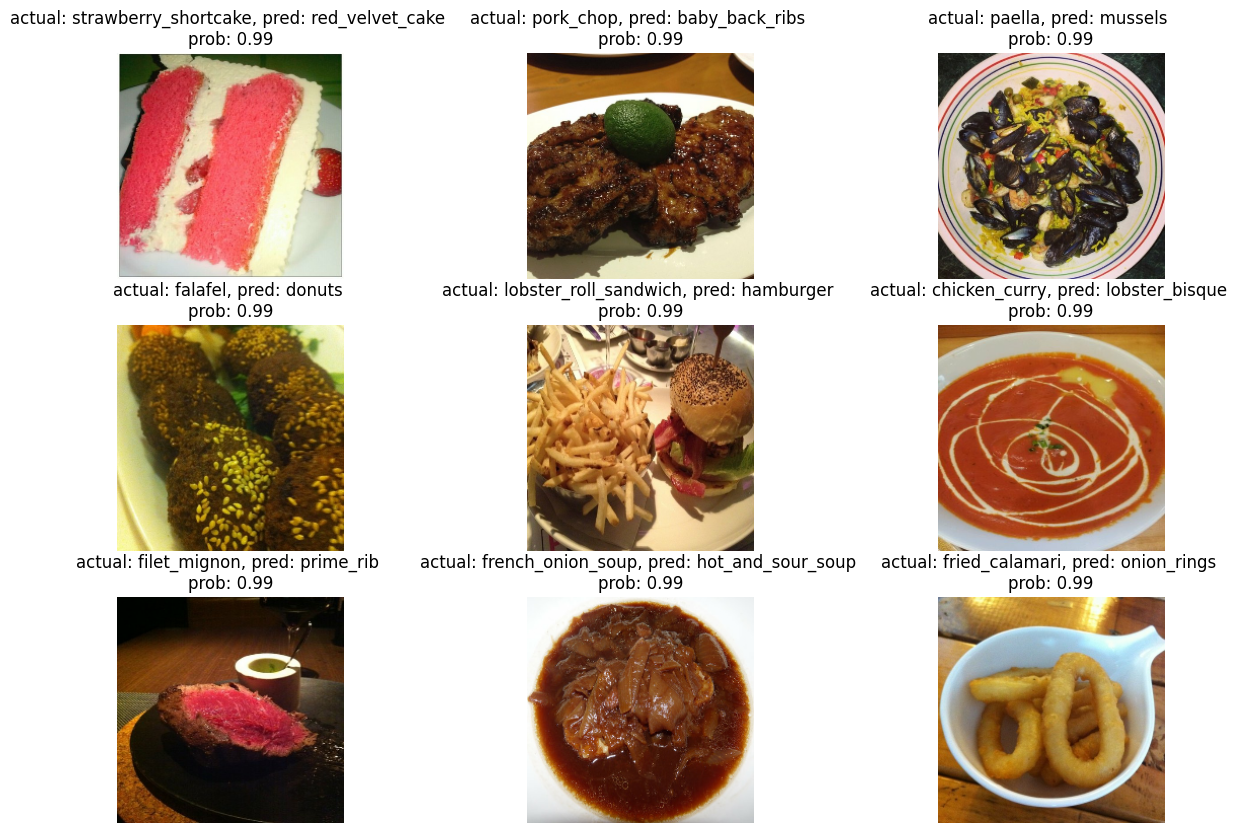

In [54]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [55]:
# Download some custom images from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-09-01 18:26:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  40.7MB/s    in 0.3s    

2023-09-01 18:26:14 (40.7 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [56]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg']

1/1 [==============================] - 0s 43ms/step


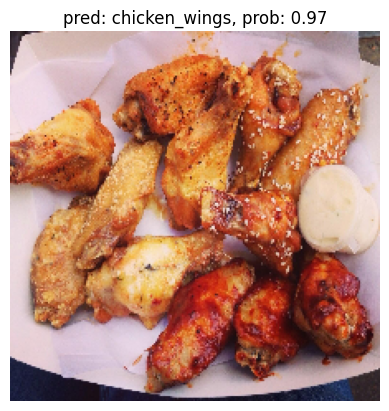

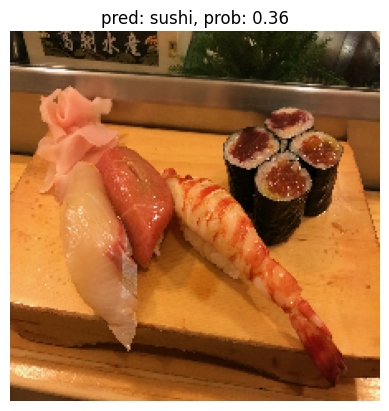

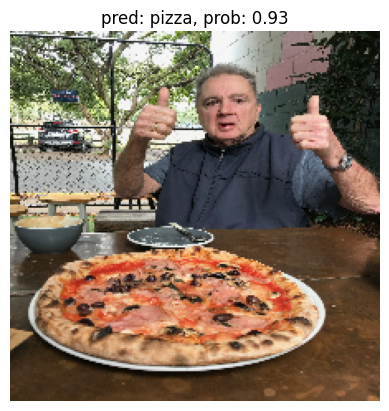

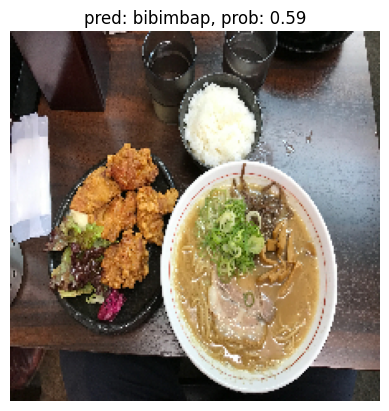

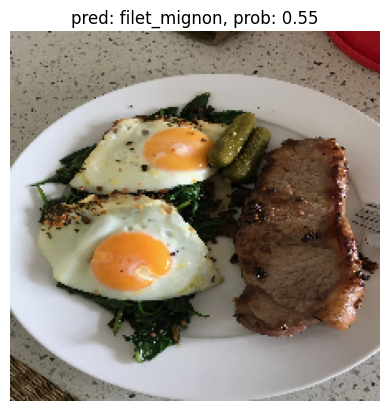

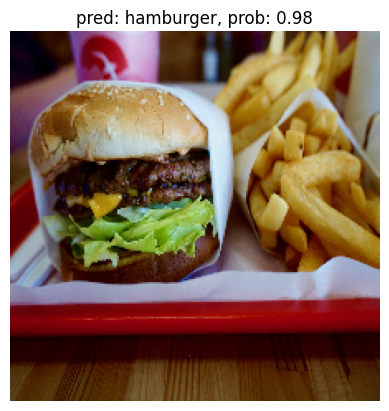

In [57]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)